# E-commerce Data Analysis
In this analysis project, we delve into the E-Commerce Data, a comprehensive dataset capturing the transactions of a UK-based and registered non-store online retail company. With a focus on customer behavior, product details, and sales records, our goal is to uncover meaningful insights that can drive strategic decision-making and business success. By exploring patterns in customer purchasing behavior, identifying top-selling products, and understanding geographic distribution, we aim to provide valuable implications for businesses in the e-commerce industry. These insights will enable companies to optimize marketing strategies, enhance customer experiences, and maximize revenue generation. Through this project, we aim to empower businesses in leveraging data-driven approaches to thrive in the dynamic and competitive e-commerce landscape.

## Content
1. Define the Problem
2. Gather the Data
3. Prepare Data for Consumption
4. Perform Exploratory Analysis
    1. Geographic Analysis
    2. Product Analysis
    3. Time Series Analysis
    4. Customer Segmentation
5. Conclusion
6. References

## 1. Define the Problem
We want to answer the following questions:
1. How does the distribution of customer transactions vary across different countries, and what strategies can be implemented to increase sales in overseas markets?
2. Which products generate the highest revenue and contribute significantly to overall sales, and how can we leverage this information to optimize product offerings and drive revenue growth?
3. Are there any recurring patterns or seasonality in monthly order volumes and revenue, and how can we align marketing efforts to capitalize on these trends and maximize sales during high-demand periods?
4. What are the distinct customer segments based on their purchasing behavior and engagement levels, and how can we effectively target and engage each segment to optimize marketing and retention strategies?

## 2. Gather the Data
We will use [E-Commerce Data](https://www.kaggle.com/datasets/carrie1/ecommerce-data?datasetId=1985&searchQuery=rfm), a publicly available dataset on <i>Kaggle</i> that was originally obtained from The <i>UCI Machine Learning Repository</i>.
- It contains data about all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
- The company mainly sells unique all-occasion gifts.
- Many customers of the company are wholesalers.
- It has the following attributes:
    - `InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
    - `StockCode`: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
    - `Description`: Product (item) name. Nominal.
    - `Quantity`: The quantities of each product (item) per transaction. Numeric.
    - `InvoiceDate`: Invice Date and time. Numeric, the day and time when each transaction was generated.
    - `UnitPrice`: Unit price. Numeric, Product price per unit in sterling.
    - `CustomerID`: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
    - `Country`: Country name. Nominal, the name of the country where each customer resides.

## 3. Prepare Data for Consumption

### 3.1 Overview

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import datetime as dt

In [87]:
transactions_df = pd.read_csv('data.csv', encoding='latin-1')
transactions_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [88]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [89]:
# check null
transactions_df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

array([[<AxesSubplot: title={'center': 'Quantity'}>,
        <AxesSubplot: title={'center': 'UnitPrice'}>]], dtype=object)

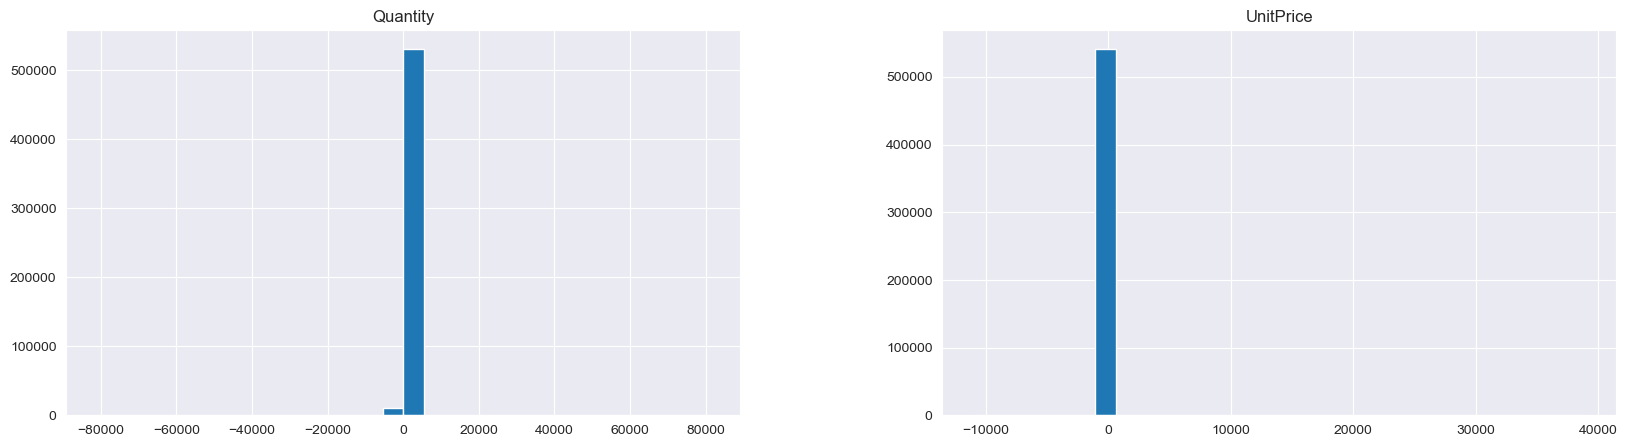

In [90]:
transactions_df[['Quantity', 'UnitPrice']].hist(bins=30, figsize=(20,5))

In [91]:
# Show statistical summary
transactions_df[['Quantity', 'UnitPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


In [92]:
num_cancelled_orders = len(transactions_df[transactions_df['InvoiceNo'].str.startswith('C')])
print(f"The number of cancelled orders are {num_cancelled_orders}.")

The number of cancelled orders are 9288.


- We see that there are missing values in Description and CustomerID.
- There are clearly outliers as shown in the distribution plots.
- The negative values in both Quantity and UnitPrice which is because of the cancelled orders.
- We also know that transactions whose 'InvoiceNo' starts with 'C' is a cancelled order.
- Furthermore, we can combine 'Quantity' and 'UnitPrice' to get a single value which we can use.
- We will fix this in the next section.

### 3.2 Data Preprocessing

In [93]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    """detect outliers with IQR method and replace with thresholds"""


    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit

    return df_

def ecommerce_preprocess(dataframe):
    """
    remove missing values,
    remove cancelled orders & quantity,
    fix outliers,
    create total price
    """

    df_ = dataframe.copy()

    #Missing Values
    df_ = df_.dropna()

    #Cancelled Orders & Quantity
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]

    #Replacing Outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)

    #Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]

    return df_

In [94]:
transactions_df = ecommerce_preprocess(transactions_df)
transactions_df[['Quantity', 'UnitPrice', 'TotalPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397924.0,11.833736,25.534512,1.0,2.00,6.00,12.00,298.500
UnitPrice,397924.0,2.893163,3.227059,0.0,1.25,1.95,3.75,37.060
TotalPrice,397924.0,20.627751,51.826400,0.0,4.68,11.80,19.80,3268.575


## 4. Perform Exploratory Analysis

### 4.1 Geographic Analysis:
We want to explore the distribution of customers across different countries and highlight countries with the highest number of customers and revenue.

In [95]:
transactions_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [96]:
# count transactions per country
transactions_per_country = transactions_df.groupby('Country').size()
transactions_per_country = transactions_per_country.sort_values(ascending=False).reset_index()
transactions_per_country.columns = ['country', 'count']
transactions_per_country['percentage'] = transactions_per_country['count'] / transactions_per_country['count'].sum()

transactions_per_country

,country,count,percentage
0,United Kingdom,354345,0.890484
1,Germany,9042,0.022723
2,France,8342,0.020964
3,EIRE,7238,0.018189
4,Spain,2485,0.006245
5,Netherlands,2363,0.005938
6,Belgium,2031,0.005104
7,Switzerland,1842,0.004629
8,Portugal,1462,0.003674
9,Australia,1185,0.002978


In [97]:
# create geographical map
fig = go.Figure(data=go.Choropleth(
    locations=transactions_per_country['country'],
    z=transactions_per_country['count'],
    locationmode='country names',
    colorscale='Reds',
    colorbar_title='Transaction Counts'
))

# set the title and the projection type
fig.update_layout(
    title_text='Transactions per  Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='robinson'
    )
)

# show plot
fig.show()


Above figure shows "Transactions per Country - Plotly geographical map"

In [99]:
# Create the treemap
fig = go.Figure(go.Treemap(
    labels=transactions_per_country['country'],
    parents=[''] * len(transactions_per_country),  # Set all parents to empty to create a single level treemap
    values=transactions_per_country['count'],
    text=round(transactions_per_country['percentage'],2),
    hovertemplate='%{label}: %{value}',
    marker=dict(
        colors=transactions_per_country['count'],
        colorscale='Reds'
    )
))

# Set the title
fig.update_layout(title_text='Transactions per Country - Treemap')

# Show the plot
fig.show()


Above figure shows "Transactions per Country - Plotly treemap"

Based on the geographic analysis of customer transactions, a significant insight is that the majority of orders, <b>approximately 89%</b>, originate from the <b>United Kingdom</b>. This finding aligns with the fact that the dataset represents a UK-based and registered non-store online retail company. While there are transactions from overseas, the substantial concentration of orders from the UK indicates a strong domestic customer base. This insight emphasizes the importance of tailoring marketing strategies, customer service, and product offerings to cater to the preferences and needs of the UK market. By focusing on the domestic customer segment, businesses can optimize their operations, enhance customer satisfaction, and drive growth within their primary market.

### 4.2 Product Analysis:
We want to identify the top-selling products based on quantity sold or revenue generated. This could give us an idea on which products are in demand.


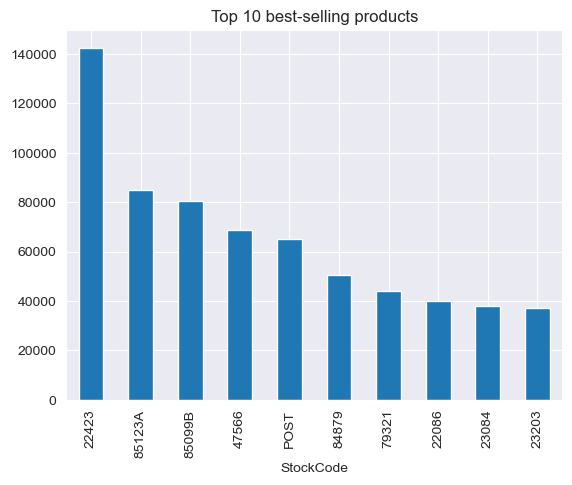

In [36]:
revenue_per_product = transactions_df.groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False)
revenue_per_product.iloc[:10].plot.bar()
plt.title("Top 10 best-selling products")
plt.show()

In [42]:
stock_code_index = transactions_df[['StockCode', 'Description']].drop_duplicates(keep='first').set_index('StockCode')
stock_code_index

,Description
StockCode,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...
90214W,"LETTER ""W"" BLING KEY RING"
90214Z,"LETTER ""Z"" BLING KEY RING"
90089,PINK CRYSTAL SKULL PHONE CHARM


In [46]:
top_3_best_selling_products = revenue_per_product.iloc[:3].index
for i, stock_code in enumerate(top_3_best_selling_products):
    print(f"Top {i+1} best selling product is {stock_code_index.loc[stock_code].values} with a total revenue of {revenue_per_product.loc[stock_code]:.2f}")

Top 1 best selling product is ['REGENCY CAKESTAND 3 TIER'] with a total revenue of 142592.95
Top 2 best selling product is [['WHITE HANGING HEART T-LIGHT HOLDER']
 ['CREAM HANGING HEART T-LIGHT HOLDER']] with a total revenue of 84967.75
Top 3 best selling product is ['JUMBO BAG RED RETROSPOT'] with a total revenue of 80327.18


Based on the product analysis and identification of top-selling products based on revenue generated, several key insights emerge. The best-selling product, <b>'REGENCY CAKESTAND 3 TIER,'</b> stands out as the top revenue generator, indicating its popularity and demand among customers. Following closely are the products 'WHITE HANGING HEART T-LIGHT HOLDER' and 'CREAM HANGING HEART T-LIGHT HOLDER,' which together contribute a substantial amount of revenue. These findings highlight the significance of attractive and unique home decor items or giftware in driving sales and generating revenue for the company. Businesses can leverage these insights to focus on stocking and promoting these high-performing products, expanding their product offerings in similar categories, and identifying opportunities to enhance customer satisfaction and increase sales.

### 4.3 Time Series Analysis:
We want to know what is the overall revenue generated during the specified period. We can identify seasonality, trends, or anomalies in the data to optimize inventory management and production planning.

In [52]:
# convert to Invoice Date datetime
transactions_df['InvoiceDate'] = pd.to_datetime(transactions_df['InvoiceDate'], format='%m/%d/%Y %H:%M')

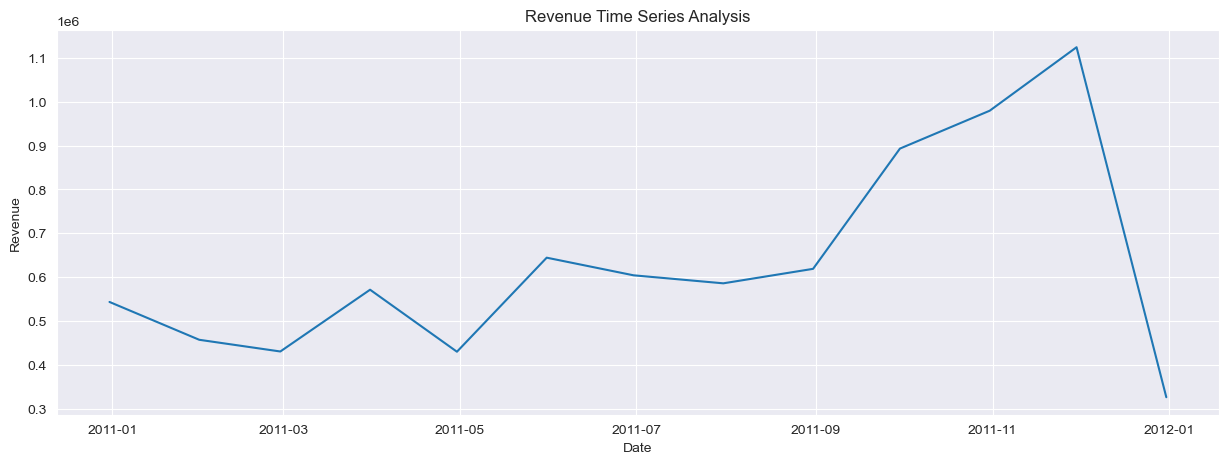

In [60]:
# group orders per month
orders_per_day = transactions_df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['TotalPrice'].sum().reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(data=orders_per_day, x='InvoiceDate', y='TotalPrice')

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue Time Series Analysis')
plt.show()

Based on the time series analysis of monthly orders and revenue, a notable insight is the significant increase in orders towards the end of the year, particularly during the months of <b>November and December</b>. This observation suggests a strong correlation with the holiday season, specifically Christmas. The surge in orders during this period can be attributed to increased consumer spending, gift purchases, and festive shopping traditions. Businesses can leverage this insight to optimize their marketing strategies, allocate resources effectively, and ensure sufficient inventory levels to meet the heightened demand during the holiday season. By aligning their operations and promotions with this seasonal trend, companies can maximize sales opportunities and drive revenue growth.

### 4.4 Customer Segmentation: RFM Analysis
RFM analysis is a customer segmentation technique that uses three key metrics: Recency, Frequency, and Monetary value. These metrics provide insights into customer behavior, allowing businesses to understand customer engagement, satisfaction, and lifetime value.

1. <b>Recency</b> refers to how recently a customer made a purchase, and it indicates their level of engagement and responsiveness to promotions. Customers who have made recent purchases are more likely to be receptive to marketing efforts.

2. <b>Frequency</b> measures how often a customer makes purchases, indicating their level of engagement and satisfaction. Customers who make frequent purchases are typically more loyal and satisfied with the company's products or services.

3. <b>Monetary</b> represents the amount of money a customer has spent, distinguishing between high-value and low-value purchasers. Customers with higher monetary value contribute more to the company's revenue and may require specific strategies to maintain their loyalty.

By analyzing these RFM factors collectively, businesses can gain valuable insights into customer segments. They can identify highly engaged and loyal customers, target customers who are likely to respond to promotions, and develop tailored marketing strategies for different customer segments. RFM analysis helps businesses improve customer retention, optimize marketing campaigns, and enhance customer experiences, ultimately driving growth and profitability.

In [74]:
today_date = dt.datetime(2011, 12, 11)

rfm = transactions_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                                 'InvoiceNo': lambda x: x.nunique(),
                                                 'TotalPrice': lambda x: x.sum()
                                                 })

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346.0,326,1,310.44
1,12347.0,3,7,4310.00
2,12348.0,76,4,1770.78
3,12349.0,19,1,1491.72
4,12350.0,311,1,331.46


In [75]:
# group recency, frequency, monetary into 5 buckets and
# assign each customer to the appropriate bucket
# these will be used to compute the RFM scores
rfm["recency_score"]   = pd.qcut(rfm["recency"], 5, labels = [5,4,3,2,1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method = "first"), 5, labels = [1,2,3,4,5])
rfm["monetary_score"]  = pd.qcut(rfm["monetary"], 5, labels = [1,2,3,4,5])
rfm["RFM_SCORE"]       = (rfm['recency_score'].astype(str) + rfm["frequency_score"].astype(str))

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346.0,326,1,310.44,1,1,2,11
1,12347.0,3,7,4310.00,5,5,5,55
2,12348.0,76,4,1770.78,2,4,4,24
3,12349.0,19,1,1491.72,4,1,4,41
4,12350.0,311,1,331.46,1,1,2,11


In [80]:
# now we can perform customer segmentation.
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_lose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)
customer_segmentation = rfm.groupby('segment').size()
customer_segmentation

segment
about_to_sleep          352
at_Risk                 593
cant_lose                63
champions               633
hibernating            1071
loyal_customers         819
need_attention          187
new_customers            42
potential_loyalists     484
promising                94
dtype: int64

In [85]:
# Create the treemap for customer segmentation
fig = go.Figure(go.Treemap(
    labels=customer_segmentation.index,
    parents=[''] * len(df),  # Set all parents to empty to create a single level treemap
    values=customer_segmentation.values,
    text=customer_segmentation.values,
    hovertemplate='%{label}: %{value}',
))

# Set the title
fig.update_layout(title_text='Customer Segmentation - Treemap')

# Show the plot
fig.show()

# i have large values for hibernating, loyal customers, followed by champion,at risk, about to sleep, then potential loyalists. other categories are smaller.

Above figure shows "Customer Segmentation - Plotly Treemap"

The customers were segmented in the following categories:
1. ``Hibernating``: These are customers who have low recency and frequency scores. They haven't made a purchase recently and their purchase frequency is also low. They require targeted efforts to re-engage them and bring them back to active purchasing.

2. ``At Risk``: Customers in this segment have made purchases in the past, but their recency score is low and frequency is moderate. They may be losing interest or engagement with the business. It's important to take proactive measures to prevent them from becoming inactive or churned customers.

3. ``Can't Lose``: These customers have high recency and frequency scores, indicating that they are highly engaged and loyal. They have the potential to become champions and should be nurtured with personalized offers and excellent customer service.

4. ``About to Sleep``: Customers in this segment have a moderate recency score but low frequency. They may be at risk of becoming inactive or dormant. Targeted strategies can be implemented to encourage them to make more frequent purchases.

5. ``Need Attention``: Customers in this segment have a moderate recency score but low monetary value. Although they have made recent purchases, their spending is relatively low. Efforts should be made to increase their average order value and overall spending.

6. ``Loyal Customers``: These customers have high recency, frequency, and monetary scores. They are highly engaged and loyal to the business. Maintaining their satisfaction and loyalty should be a priority to ensure
continued business growth.

7. ``Promising``: Customers in this segment have a low recency score but a moderate frequency score. They have the potential to become more engaged and loyal with the right marketing strategies and incentives.

8. ``New Customers``: This segment consists of customers who have recently made their first purchase. They require onboarding and nurturing to convert them into repeat customers.

9. ``Potential Loyalists``: These customers have moderate to high frequency scores but lower recency scores. They show potential to become loyal customers with targeted marketing and retention efforts.

10. ``Champions``: Customers in this segment have high scores across all RFM metrics, indicating their high engagement, frequency, and monetary value. They are the most valuable and loyal customers who can serve as advocates for the business.

The largest customer segment consists of "Hibernating" customers, indicating a significant portion of customers who haven't made recent purchases and have low engagement. This presents an opportunity to implement targeted re-engagement strategies, such as personalized promotions or loyalty programs, to revive their interest and encourage repeat purchases. Additionally, the presence of a sizable "Loyal Customers" segment highlights the importance of nurturing and retaining these valuable customers through exclusive offers, exceptional customer service, and rewards programs. The "Champions" segment represents highly engaged and loyal customers who can serve as brand advocates, and efforts should be made to maintain their satisfaction and encourage positive word-of-mouth. The "At Risk," "About to Sleep," and "Potential Loyalists" segments suggest customers who may require proactive measures to prevent churn, such as targeted incentives and personalized communication. By focusing on these actionable insights, businesses can optimize their marketing strategies, strengthen customer relationships, and drive long-term growth and profitability.

## 5. Conclusion

Through our comprehensive analysis of the E-Commerce Data, we have gained valuable insights that can inform strategic decision-making and drive business growth in the online retail industry.
- Firstly, by examining the geographic distribution of customer transactions, we discovered that the majority of orders originate from the United Kingdom, highlighting the importance of tailoring marketing strategies and product offerings to the preferences of the domestic market. To increase sales in overseas markets, targeted expansion efforts and localized marketing campaigns can be implemented.
- Secondly, by identifying the top-selling products based on revenue generated, we uncovered the significant revenue contributions of products such as 'REGENCY CAKESTAND 3 TIER,' 'WHITE HANGING HEART T-LIGHT HOLDER,' and 'CREAM HANGING HEART T-LIGHT HOLDER.' Leveraging this information, businesses can optimize their product offerings, focus on high-performing items, and explore opportunities in similar categories to drive revenue growth.
- Furthermore, our time series analysis revealed a strong correlation between increased orders and the holiday season, particularly in November and December. By aligning marketing efforts and ensuring sufficient inventory during these peak periods, businesses can maximize sales opportunities and capitalize on heightened consumer spending.
- Lastly, our customer segmentation analysis provided insights into distinct customer behavior segments, offering opportunities to implement targeted marketing and retention strategies. Strategies for re-engaging "Hibernating" customers, nurturing "Loyal Customers," and leveraging the advocacy of "Champions" can optimize customer relationships and drive long-term growth. In conclusion, these insights address our initial questions and provide businesses with actionable recommendations to enhance their market presence, optimize operations, and maximize revenue generation in the competitive e-commerce landscape.

## 6. References
[Python | Geographical plotting using plotly](https://lightupthesky1111.medium.com/python-geographical-plotting-using-plotly-f18e3f590f7f) - cool guide showing how to make geographical plots.
[RFM analysis (recency, frequency, monetary) ](https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis) - gives an explanation of what is RFM analysis and how to perform it.
[Titanic Data Science Solutions](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/notebook) - A kaggle notebook which goes over the common workflow for data science solutions.
